<a href="https://colab.research.google.com/github/kartikbandarwad99/Crypto/blob/main/Rfm_2_pre-final%20check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Import and Preprocessing

In [ ]:
#!pip install -U kaleido

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [5]:
df = pd.read_csv("Activities Export 20240710.csv")
df.head()

,obfuscated_id,action,subject_type,obfuscated_account_id,created_at
0,4053526,21,Person,2985.0,2024-07-10 18:13:41.484038
1,4053525,13,FirmAdmin::CapitalAccount,2591.0,2024-07-10 18:13:36.877983
2,4053524,12,Person,2263.0,2024-07-10 18:13:34.433866
3,4053523,11,Person,2263.0,2024-07-10 18:13:34.424491
4,4053522,11,Person,2263.0,2024-07-10 18:13:34.350379


In [6]:
df.shape

(1380847, 5)

In [7]:
df['created_at'] = pd.to_datetime(df['created_at'], format='mixed')
df[:2]['created_at'].dt.month

0    7
1    7
Name: created_at, dtype: int32

In [8]:
# Dropping the duplicates, since it is highly unlikely that multiple
# actions with same account happen at the same time with microsecond accuracy
df1=df[~df['obfuscated_account_id'].isna()]
df1=df1.drop_duplicates(subset=df.columns[1:])
df1.shape

(1300215, 5)

In [9]:
df1.obfuscated_account_id.nunique()

2090

In [10]:
recency_data = df1.groupby('obfuscated_account_id')['created_at'].max().reset_index()
recency_data.head()

,obfuscated_account_id,created_at
0,10.0,2024-07-02 01:25:11.153225
1,13.0,2024-05-13 09:05:37.390452
2,16.0,2024-06-26 15:00:28.321219
3,20.0,2024-07-02 01:17:03.503255
4,33.0,2024-07-02 01:17:03.638026


In [11]:
most_recent_date = pd.to_datetime('2024-07-10 12:00:00')
recency_data['Recency'] = (most_recent_date - recency_data['created_at']).dt.days
recency_data= recency_data.drop(columns='created_at')
recency_data.head()

,obfuscated_account_id,Recency
0,10.0,8
1,13.0,58
2,16.0,13
3,20.0,8
4,33.0,8


In [12]:
recency_data[recency_data['Recency']<0]['Recency'].unique()

array([ -1, -64,  -5, -22])

In [13]:
frequency_data = df1.groupby('obfuscated_account_id')['obfuscated_account_id'].count().reset_index(name='Frequency')

# Merge Recency and Frequency data
rfm_data = recency_data.merge(frequency_data, on='obfuscated_account_id')
rfm_data.head()

,obfuscated_account_id,Recency,Frequency
0,10.0,8,1041
1,13.0,58,3
2,16.0,13,2
3,20.0,8,14
4,33.0,8,3


In [14]:
# Some columns have negative recency because they contain data from dates
# in the future relative to the current date.
rfm_data1=rfm_data[rfm_data['Recency']>=0]

# Basic EDA and variable Creation

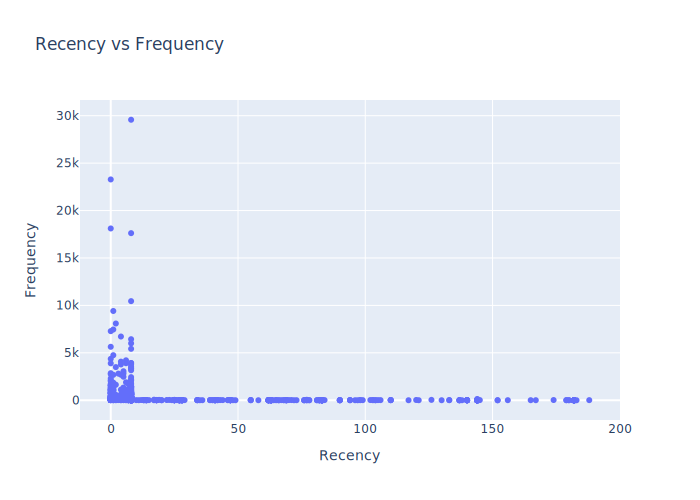

In [49]:
fig = go.Figure(data=go.Scatter(x=rfm_data1['Recency'], y=rfm_data1['Frequency'], mode='markers'))
fig.update_layout(
    title='Recency vs Frequency',
    xaxis_title="Recency",
    yaxis_title="Frequency"
)
fig.show("svg")


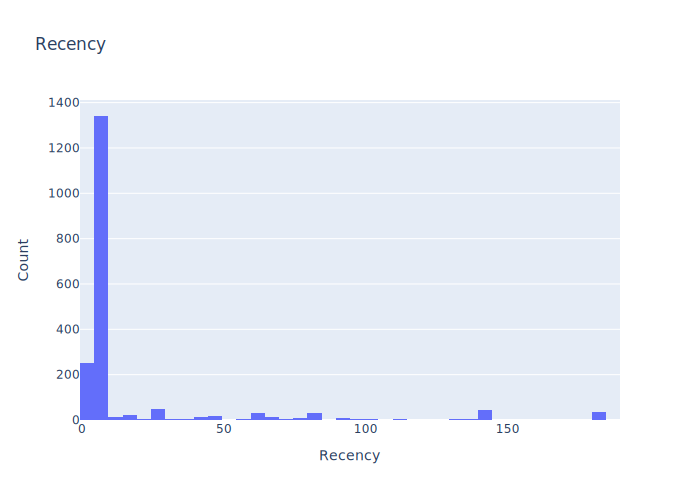

In [50]:
fig = go.Figure(data=[go.Histogram(x=rfm_data1['Recency'], nbinsx=50)])
fig.update_layout(
    title='Recency',
    xaxis_title="Recency",
    yaxis_title="Count"
)
fig.show("svg")

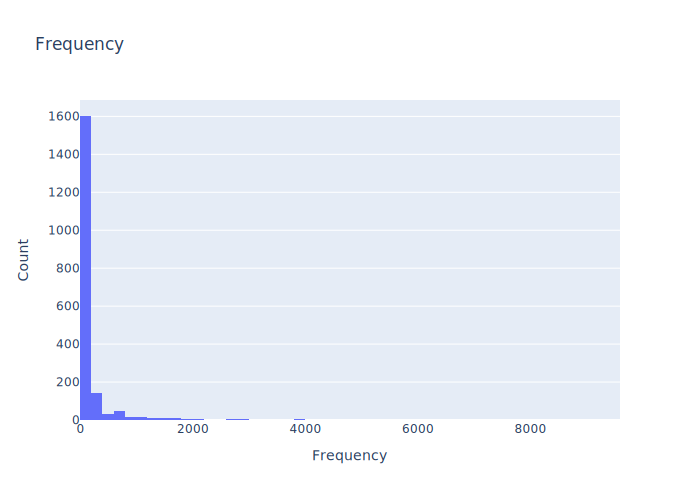

In [52]:
fig = go.Figure(data=[go.Histogram(x=rfm_data1[rfm_data1['Frequency']<10000]['Frequency'], nbinsx=50)])
fig.update_layout(
    title='Frequency',
    xaxis_title="Frequency",
    yaxis_title="Count"
)
fig.show("svg")

In [20]:
def assign_recency_score(recency):
  if recency >= 0 and recency <= 7:
    return 5
  elif recency > 7 and recency <= 14:
    return 4
  elif recency > 15 and recency <= 30:
    return 3
  elif recency > 30 and recency <= 45:
    return 2
  # elif recency > 45 and recency <= 60:
  #   return 2
  else:
    return 1

rfm_data1.loc[:,'RecencyScore'] = rfm_data1['Recency'].apply(assign_recency_score)
rfm_data1.head()

<ipython-input-20-76dc6691e9d6>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,obfuscated_account_id,Recency,Frequency,RecencyScore
0,10.0,8,1041,4
1,13.0,58,3,1
2,16.0,13,2,4
3,20.0,8,14,4
4,33.0,8,3,4


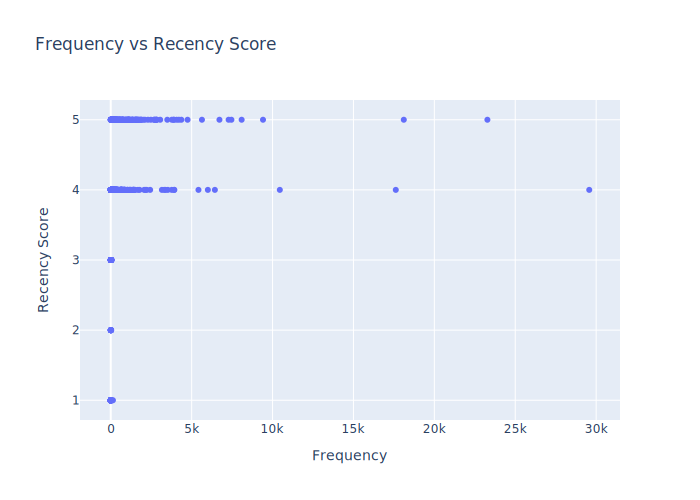

In [53]:
fig = go.Figure(data=go.Scatter(x=rfm_data1['Frequency'], y=rfm_data1['RecencyScore'], mode='markers'))
fig.update_layout(
    title='Frequency vs Recency Score',
    xaxis_title="Frequency",
    yaxis_title="Recency Score"
)
fig.show("svg")

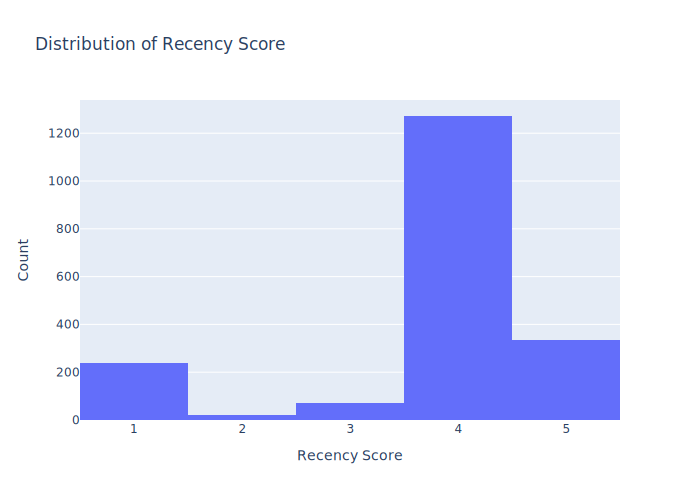

In [54]:
fig = go.Figure(data=[go.Histogram(x=rfm_data1['RecencyScore'])])
fig.update_layout(
    title='Distribution of Recency Score',
    xaxis_title="Recency Score",
    yaxis_title="Count"
)
fig.show("svg")

In [25]:
# Calculate the number of days for each account ID
num_days_data = df1.groupby('obfuscated_account_id')['created_at'].apply(lambda x: x.dt.date.nunique()).reset_index(name='NumDays')

# Merge the number of days data into rfm_data1
rfm_data1 = rfm_data1.merge(num_days_data, on='obfuscated_account_id')

rfm_data1.head()

,obfuscated_account_id,Recency,Frequency,RecencyScore,NumDays
0,10.0,8,1041,4,1
1,13.0,58,3,1,2
2,16.0,13,2,4,1
3,20.0,8,14,4,4
4,33.0,8,3,4,2


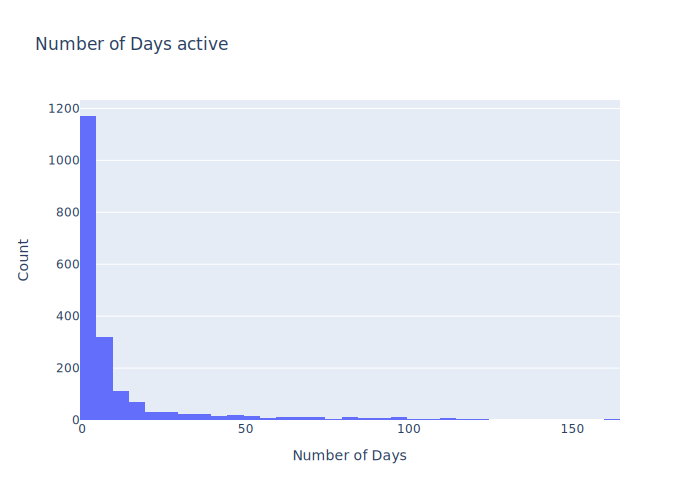

In [56]:
fig = go.Figure(data=[go.Histogram(x=rfm_data1['NumDays'], nbinsx=40)])
fig.update_layout(
    title='Number of Days active',
    xaxis_title="Number of Days",
    yaxis_title="Count"
)
fig.show("svg")

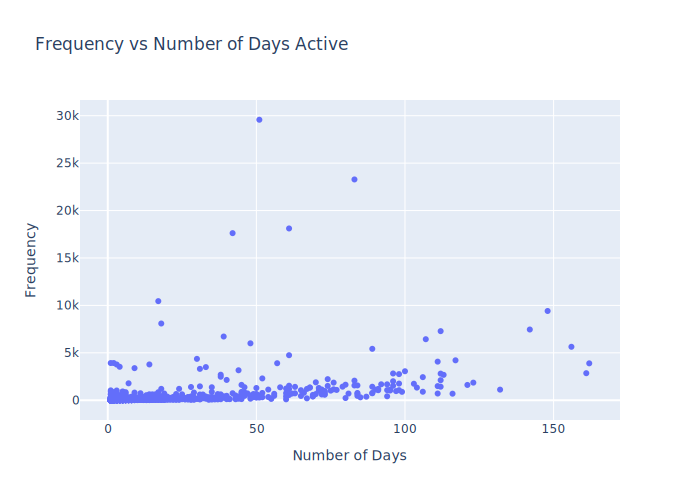

In [57]:
fig = go.Figure(data=go.Scatter(x=rfm_data1['NumDays'], y=rfm_data1['Frequency'], mode='markers'))
fig.update_layout(
    title='Frequency vs Number of Days Active',
    xaxis_title="Number of Days",
    yaxis_title="Frequency"
)
fig.show("svg")

In [28]:
rfm_data1['NumDays'].corr(rfm_data1['Frequency'])

0.42411698504872447

In [29]:
print("for less than 10 days: max days- {} min days- {}".format(rfm_data1[rfm_data1['NumDays']<10]['NumDays'].max(),rfm_data1[rfm_data1['NumDays']<10]['NumDays'].min()))
print("for less than 10 days: max days- {} min days- {}".format(rfm_data1[rfm_data1['NumDays']>=10]['NumDays'].max(),rfm_data1[rfm_data1['NumDays']>=10]['NumDays'].min()))

for less than 10 days: max days- 9 min days- 1
for less than 10 days: max days- 162 min days- 10


In [30]:
def assign_num_days_bin(num_days):
  if num_days >= 0 and num_days <= 4:
    return 1
  elif num_days >= 5 and num_days <= 9:
    return 2
  elif num_days >= 10 and num_days <= 20:
    return 3
  elif num_days > 20 and num_days <= 30:
    return 4
  else:
    return 5

rfm_data1['NumDaysBin'] = rfm_data1['NumDays'].apply(assign_num_days_bin)
rfm_data1.head()

,obfuscated_account_id,Recency,Frequency,RecencyScore,NumDays,NumDaysBin
0,10.0,8,1041,4,1,1
1,13.0,58,3,1,2,1
2,16.0,13,2,4,1,1
3,20.0,8,14,4,4,1
4,33.0,8,3,4,2,1


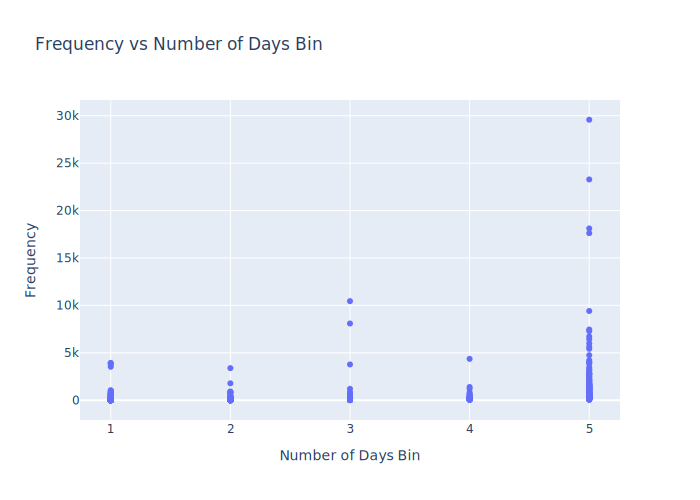

In [58]:
fig = go.Figure(data=go.Scatter(x=rfm_data1['NumDaysBin'], y=rfm_data1['Frequency'], mode='markers'))
fig.update_layout(
    title='Frequency vs Number of Days Bin',
    xaxis_title="Number of Days Bin",
    yaxis_title="Frequency"
)
fig.show("svg")

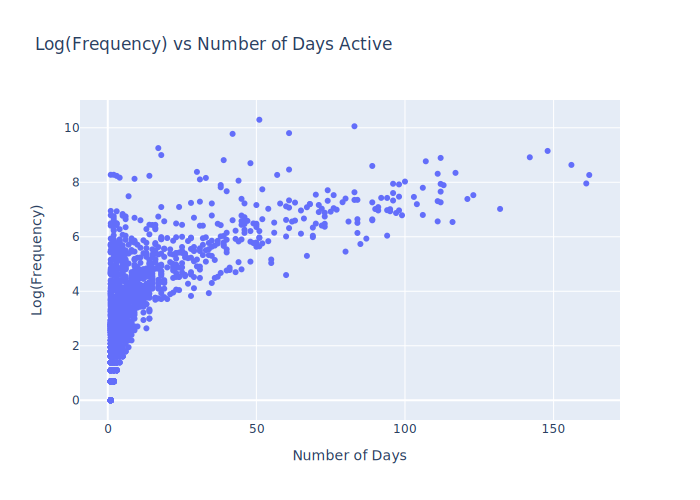

In [59]:
fig = go.Figure(data=go.Scatter(x=rfm_data1['NumDays'], y=np.log(rfm_data1['Frequency']), mode='markers'))
fig.update_layout(
    title='Log(Frequency) vs Number of Days Active',
    xaxis_title="Number of Days",
    yaxis_title="Log(Frequency)"
)
fig.show("svg")

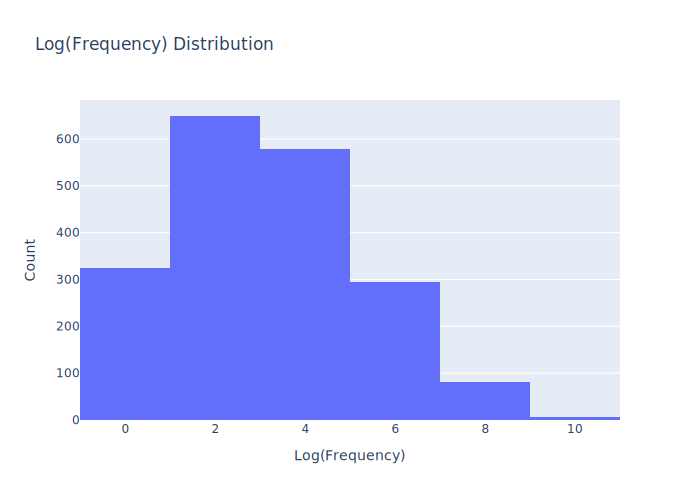

In [60]:
fig = go.Figure(data=[go.Histogram(x=np.log(rfm_data1['Frequency']), nbinsx=10)])
fig.update_layout(
    title="Log(Frequency) Distribution",
    xaxis_title="Log(Frequency)",
    yaxis_title="Count"
)
fig.show("svg")

In [34]:
print(np.exp(0))
print(np.exp(1))
print(np.exp(3))
print(np.exp(5))
print(np.exp(7))
print(np.exp(9))
print(np.exp(11))

1.0
2.718281828459045
20.085536923187668
148.4131591025766
1096.6331584284585
8103.083927575384
59874.14171519782


In [35]:
import numpy as np
def assign_frequency_score(frequency):
  if frequency >= 0 and frequency <= np.exp(1):
    return 1
  elif frequency > np.exp(1) and frequency <= np.exp(3):
    return 2
  elif frequency > np.exp(3) and frequency <= np.exp(5):
    return 3
  elif frequency > np.exp(5) and frequency <= np.exp(7):
    return 4
  else:
    return 5

rfm_data1['FrequencyScore'] = rfm_data1['Frequency'].apply(assign_frequency_score)
rfm_data1.head()

,obfuscated_account_id,Recency,Frequency,RecencyScore,NumDays,NumDaysBin,FrequencyScore
0,10.0,8,1041,4,1,1,4
1,13.0,58,3,1,2,1,2
2,16.0,13,2,4,1,1,1
3,20.0,8,14,4,4,1,2
4,33.0,8,3,4,2,1,2


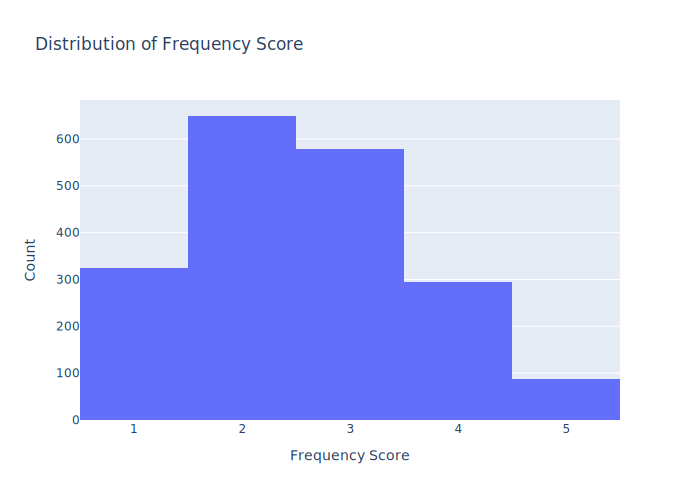

In [61]:
fig = go.Figure(data=[go.Histogram(x=rfm_data1['FrequencyScore'])])
fig.update_layout(
    title='Distribution of Frequency Score',
    xaxis_title="Frequency Score",
    yaxis_title="Count"
)
fig.show("svg")

# Recency - Frequency Matrix

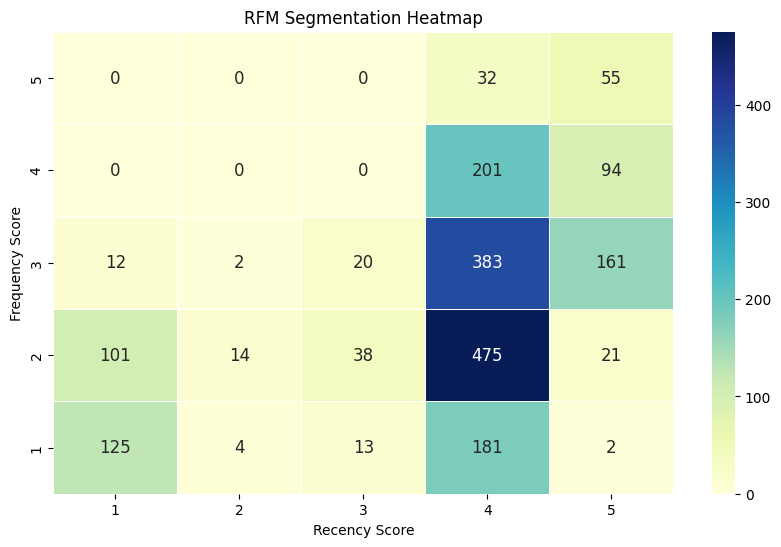

In [37]:
plt.figure(figsize=(10, 6))

sns.heatmap(
    rfm_data1.pivot_table(index='FrequencyScore' , columns='RecencyScore', values='obfuscated_account_id',
                         aggfunc='count', fill_value=0).sort_index(ascending=False),
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    linewidths=.5,
    annot_kws={"size": 12}
)

plt.title('RFM Segmentation Heatmap')
plt.xlabel('Recency Score')
plt.ylabel('Frequency Score')
plt.show()

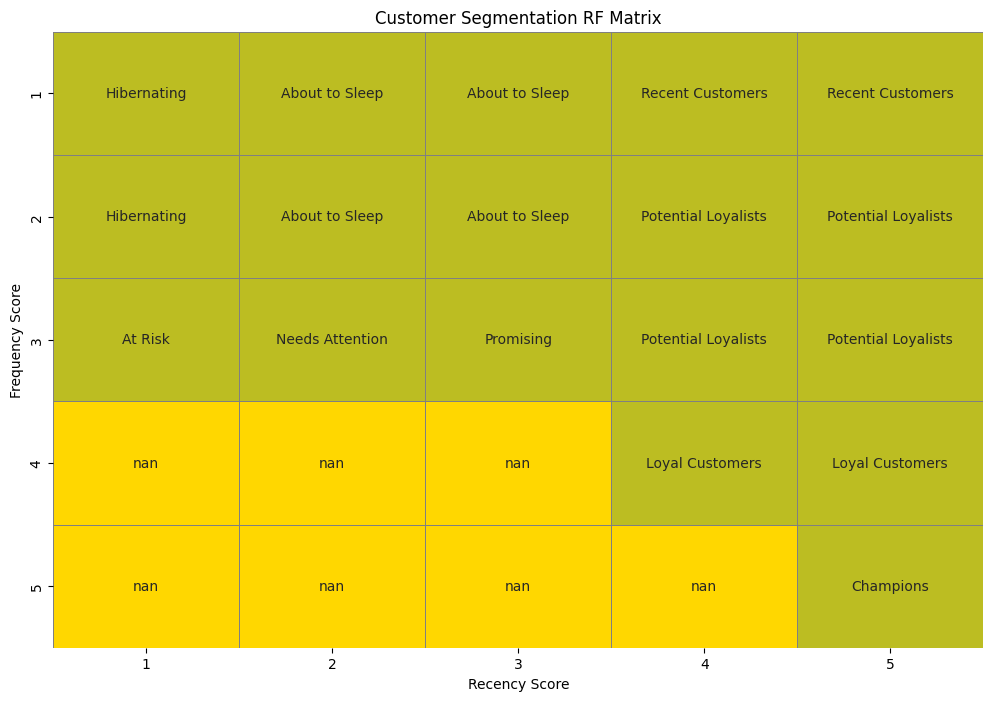

In [38]:
segment_map = {
    (5, 5): 'Champions',
    (3, 4): 'Loyal Customers', (4, 4): 'Loyal Customers', (5, 4): 'Loyal Customers',
    (4, 2): 'Potential Loyalists', (4, 3): 'Potential Loyalists', (5, 2): 'Potential Loyalists', (5, 3): 'Potential Loyalists',
    (4, 1): 'Recent Customers', (5, 1): 'Recent Customers',
    (3, 3): 'Promising',
    (2, 3): 'Needs Attention', (2, 4): 'Needs Attention',
    (2, 1): 'About to Sleep', (2, 2): 'About to Sleep', (3, 1): 'About to Sleep', (3, 2): 'About to Sleep',
    (1, 3): 'At Risk', (1, 4): 'At Risk', (1, 5): 'At Risk', (2, 5): 'At Risk',
    (1, 1): 'Hibernating', (1, 2): 'Hibernating'
}

# Map the segments
rfm_data1['Segment'] = rfm_data1.apply(lambda x: segment_map.get((x['RecencyScore'], x['FrequencyScore'])), axis=1)

# Aggregate the data to ensure unique combinations
agg_data = rfm_data1.groupby(['RecencyScore', 'FrequencyScore', 'Segment']).size().reset_index(name='Count')

# Create a pivot table for segments
pivot_segment = agg_data.pivot(index='FrequencyScore', columns='RecencyScore', values='Segment')

# Define a color palette for segments
segment_colors = {
    'Champions': '#FFD700', # Gold
    'Loyal Customers': '#1f77b4', # Blue
    'Potential Loyalists': '#2ca02c', # Green
    'Recent Customers': '#d62728', # Red
    'Promising': '#9467bd', # Purple
    'Needs Attention': '#8c564b', # Brown
    'About to Sleep': '#e377c2', # Pink
    'At Risk': '#7f7f7f', # Grey
    'Hibernating': '#bcbd22' # Olive
}

# Apply the color map
color_matrix = pivot_segment.applymap(lambda x: segment_colors.get(x, '#FFFFFF'))

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_segment.applymap(lambda x: 1 if pd.notna(x) else 0), annot=pivot_segment, fmt='', cmap=sns.color_palette(list(segment_colors.values())), cbar=False, linewidths=0.5, linecolor='gray')
plt.title('Customer Segmentation RF Matrix')
plt.xlabel('Recency Score')
plt.ylabel('Frequency Score')
plt.show()

In [39]:
pivot_segment.loc[:,:]

RecencyScore,1,2,3,4,5
FrequencyScore,,,,,
1,Hibernating,About to Sleep,About to Sleep,Recent Customers,Recent Customers
2,Hibernating,About to Sleep,About to Sleep,Potential Loyalists,Potential Loyalists
3,At Risk,Needs Attention,Promising,Potential Loyalists,Potential Loyalists
4,NaN,NaN,NaN,Loyal Customers,Loyal Customers
5,NaN,NaN,NaN,NaN,Champions


# Other variables

In [42]:
def group_subject_type(subject):
  if 'FirmAdmin' in subject:
    return 'Firm Admin'
  else:
    return subject

df1['subject_type_grouped'] = df1['subject_type'].apply(group_subject_type)

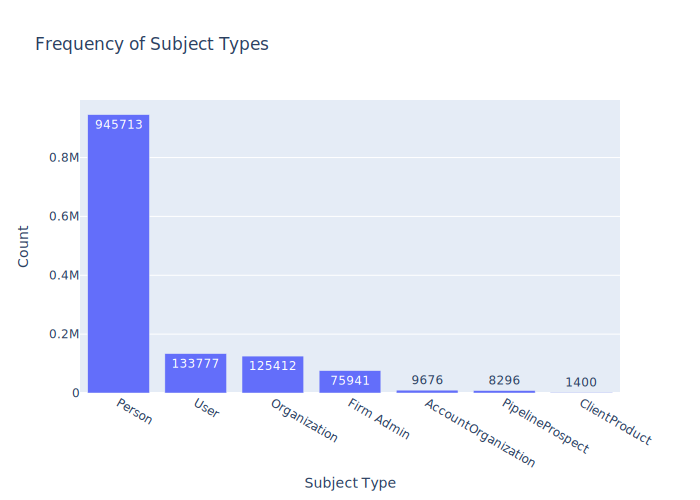

In [67]:
subject_counts = df1['subject_type_grouped'].value_counts()

fig = go.Figure(data=[go.Bar(x=subject_counts.index, y=subject_counts.values, text=subject_counts.values, textposition='auto')])

fig.update_layout(
    title='Frequency of Subject Types',
    xaxis_title='Subject Type',
    yaxis_title='Count'
)

fig.show("svg")


***Major actions being performed by Person/User, Organization and Firm Admin related***


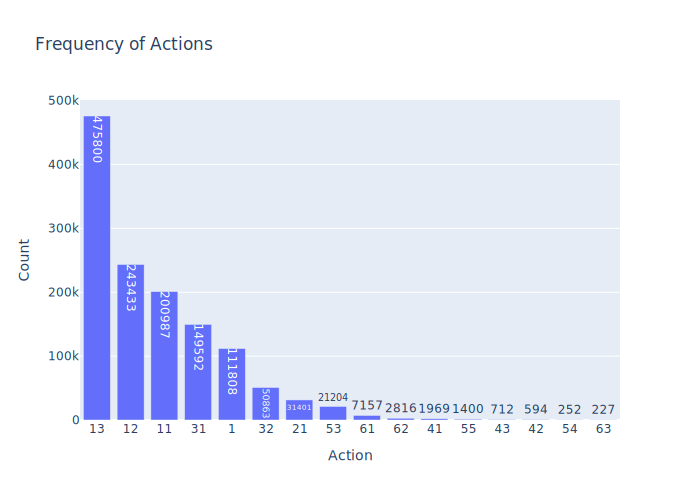

In [68]:
action_counts = df1['action'].astype(str).value_counts()

fig = go.Figure(data=[go.Bar(x=action_counts.index, y=action_counts.values,text=action_counts.values, textposition='auto')])

fig.update_layout(
    title='Frequency of Actions',
    xaxis_title='Action',
    yaxis_title='Count'
)

fig.show("svg")


**Major actions performed are 13,12,11,31,1 and 32**
*user_activity: 1*

*subject_created: 11*

*subject_moved: 12*

*subject_edited: 13*

*subject_tag_added: 14*

*email_dispatched: 31*

*email_link_clicked: 32*

<Axes: xlabel='subject_type_grouped', ylabel='action'>

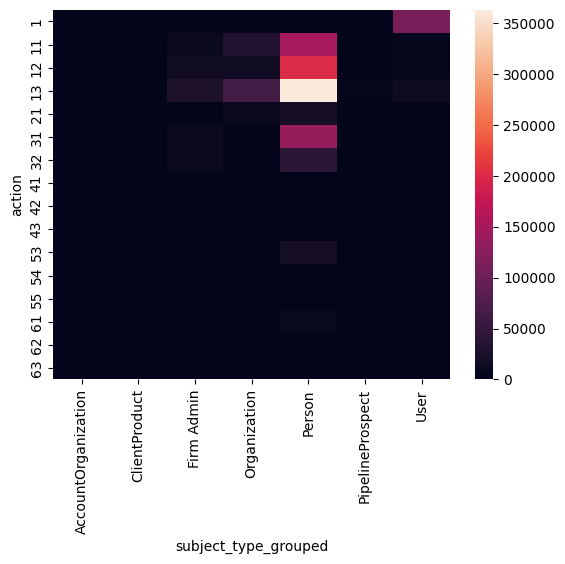

In [74]:
sns.heatmap(pd.pivot_table(df1, index='action', columns='subject_type_grouped', values='obfuscated_account_id', aggfunc='count', fill_value=0))